## Where do embeddings come from?
### Embedding MNIST images and NLP sentences into vectors.


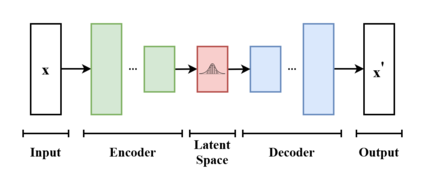

[Source](https://en.wikipedia.org/wiki/Variational_autoencoder)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [2]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [4]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [5]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

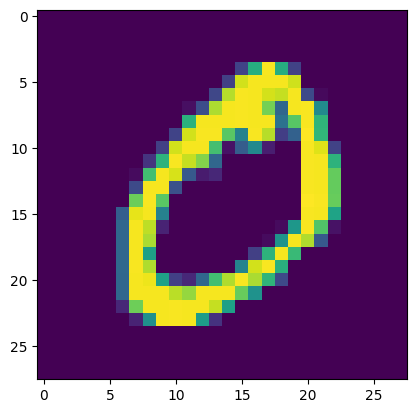

In [6]:
# Example of a training image
plt.imshow(x_tr[1]);

In [7]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [8]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [9]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')

z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [10]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

### Visualize Embeddings

In [ ]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

In [ ]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

## Example: compare three embeddings

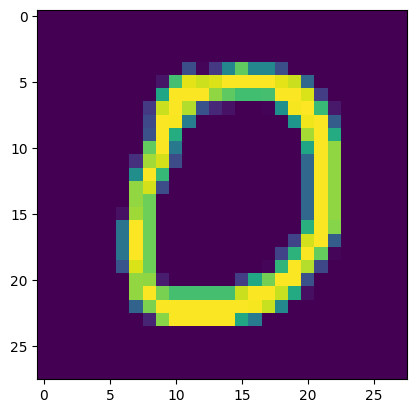

In [17]:
plt.imshow(x_te_flat[10].reshape(28,28));

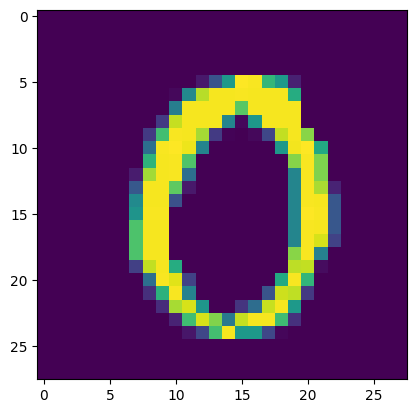

In [18]:
plt.imshow(x_te_flat[13].reshape(28,28));

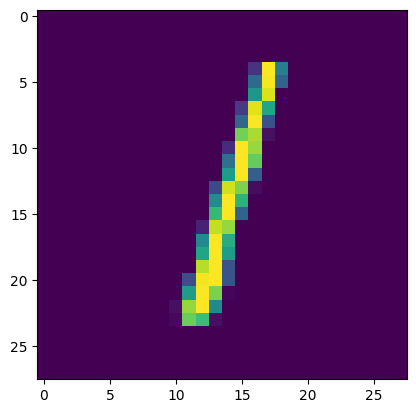

In [19]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [20]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  tensor([2.0530, 0.5875])
Embedding for the second ZERO is tensor([1.6914, 0.5407])
Embedding for the ONE is         tensor([-2.2389,  0.2750])


## Using more advanced models based on the Transformer architechture you can embed sentences aswell.

In [21]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [23]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.37061977  0.26414245  0.21265678 ...  0.14994559 -0.2579491
  -0.23970762]
 [ 0.6693327   0.40094954 -0.48208416 ...  0.10645907 -1.5067159
  -0.01547337]
 [-0.26555938  0.11172415 -0.14733033 ...  0.4219748   0.88394576
   0.10763928]]


In [24]:
embedding.shape

(3, 384)

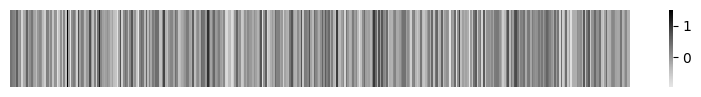

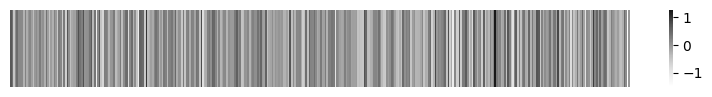

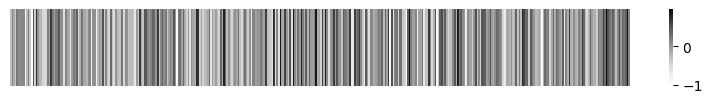

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

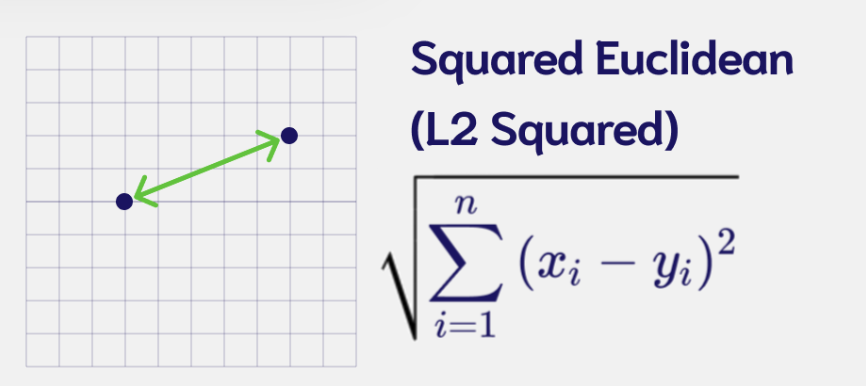

In [26]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.36461088


In [27]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

np.float32(0.36461088)

In [28]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.36461088
Distance zeroA-one:   4.3032827
Distance zeroB-one:   3.9392982


### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

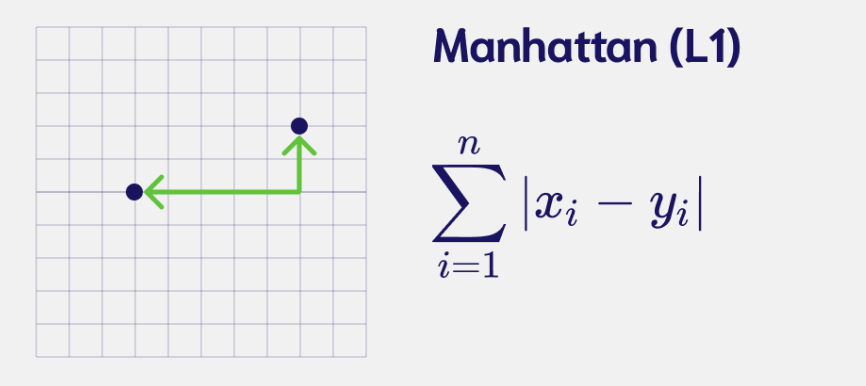

In [29]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

0.40841228


In [30]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

np.float32(0.40841228)

In [31]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 0.40841228
Distance zeroA-one:   4.6044273
Distance zeroB-one:   4.196015


### Dot Product
Measures the magnitude of the projection of one vector onto the other.

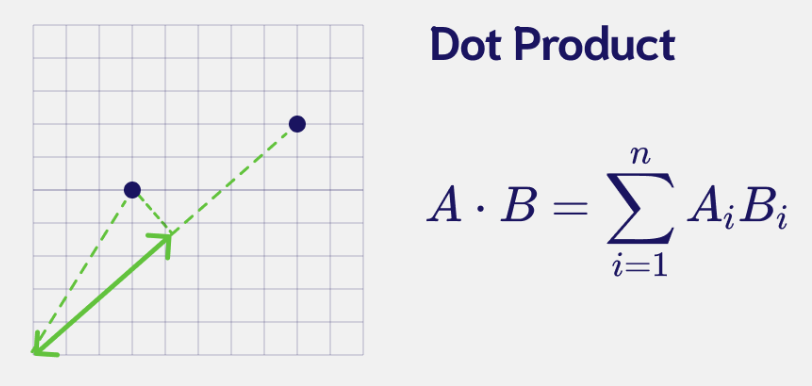

In [32]:
# Dot Product
np.dot(zero_A,zero_B)

/tmp/ipython-input-4074761123.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.dot(zero_A,zero_B)


np.float32(3.790237)

In [33]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 3.790237
Distance zeroA-one:   -4.434959
Distance zeroB-one:   -3.6382706


/tmp/ipython-input-2393363018.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
/tmp/ipython-input-2393363018.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print("Distance zeroA-one:  ", np.dot(zero_A, one))
/tmp/ipython-input-2393363018.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print("Distance zeroB-one:  ", np.dot(zero_B, one))


### Cosine Distance
Measure the difference in directionality between vectors.

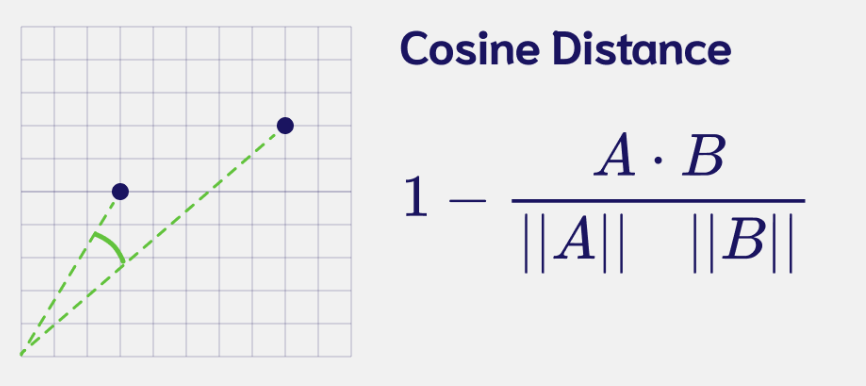

In [34]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.000471


/tmp/ipython-input-504519565.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))


In [35]:
zero_A/zero_B

tensor([1.2138, 1.0866])

In [36]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [37]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.000471
Distance zeroA-one:    1.920702
Distance zeroB-one:    1.908299


/tmp/ipython-input-4221253553.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))


## Now with the sentence embeddings!

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [38]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497887
Distance 0-2: 2.078577
Distance 1-2: 4.0192127


In [39]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350336
Distance 0-2:  0.9639393
Distance 1-2:  0.9288791


# +++Refactor to PyTorch Task
Refactor the TensorFlow Keras VAE code for embedding MNIST images and NLP sentences into vectors to PyTorch syntax.

## Define the pytorch vae model

### Subtask:
Create a PyTorch module for the VAE, including the encoder, decoder, and the reparameterization trick.


**Reasoning**:
Import the necessary PyTorch modules and define the VAE components (Encoder, Decoder, and VAE model) as PyTorch classes.



In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    # create layers
    # self = the 'Encoder' class obj
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        # super = parent class nn.Module
        # simpler syntax
        # super().__init__() calls contructor of parent class nn.Module
        # vs
        # complex syntax (for complex class inheritance patterns
        #                 - eg when subclass inherits from 2 parent classes)
        # super(Encoder, self).__init__()
        #     Encoder => tells 'super' to refer to 'Encoder' class' parent -> nn.Module
        #     self => 'Encoder' class obj, passed to super/parent class
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)

        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim2, latent_dim)

    # use layers
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))

        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

class Decoder(nn.Module):
    # create layers
    def __init__(self, latent_dim, hidden_dim2, hidden_dim1, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, output_dim)

    # use layers
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        # add a sigmoid layer for classification
        return torch.sigmoid(self.fc3(h))

class VAE(nn.Module):
    # create layers
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim2, hidden_dim1, input_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    # use layers
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var

## Implement the vae loss function in pytorch

### Subtask:
Translate the Keras VAE loss (reconstruction loss + KL divergence) into a PyTorch loss function.


**Reasoning**:
Define a PyTorch function to calculate the VAE loss, combining reconstruction loss and KL divergence.



In [12]:
def vae_loss_function(reconstruction, x, mu, log_var):
    # Reconstruction loss using binary cross-entropy
    reconstruction_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')

    # KL divergence loss
    kl_loss = 0.5 * torch.sum(torch.exp(log_var) + mu**2 - 1. - log_var)

    # Total VAE loss
    total_loss = reconstruction_loss + kl_loss
    return total_loss

## Set up the pytorch training loop

### Subtask:
Write the training loop in PyTorch, including optimizer definition, forward pass, backward pass, and loss calculation.


**Reasoning**:
Implement the training loop in PyTorch, including optimizer definition, DataLoader creation, forward pass, backward pass, and loss calculation, and print the epoch loss.



In [13]:
from tensorflow.keras.datasets import mnist

# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2


###############
# DATASET
###############
# Load and flatten data again as the variable is not available
# training vs test set
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
# normalise pixels from 0-255 to 0.0-1.0
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
# reshape each 2D img matrix into 1D vectors
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)



###############
# MODEL
###############
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming VAE and vae_loss_function are defined in previous cells

# Instantiate the VAE model
input_dim = x_tr_flat.shape[1]
hidden_dim1 = n_hidden
hidden_dim2 = n_hidden // 2
latent_dim = z_dim

vae_flat = VAE(input_dim, hidden_dim1, hidden_dim2, latent_dim)

# 1. Define the PyTorch optimizer
optimizer = optim.Adam(vae_flat.parameters(), lr=1e-3)

# Convert numpy array to torch tensor
x_tr_tensor = torch.tensor(x_tr_flat, dtype=torch.float32)

# 2. Create a PyTorch DataLoader
train_dataset = TensorDataset(x_tr_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(n_epoch):
    total_loss = 0
    for batch_idx, data in enumerate(train_loader):
        # 5. Forward pass
        x_batch = data[0]
        reconstruction, mu, log_var = vae_flat(x_batch)

        # 6. Calculate the VAE loss
        loss = vae_loss_function(reconstruction, x_batch, mu, log_var)

        # 7. Backward pass and optimize
        # RESET gradients of params to 0
        # SO gradients from previous bkwd pass dont accumulate/pass on to below
        optimizer.zero_grad()
        # backpropagate/CALCULATE param gradients for the current batch
        loss.backward()
        # UPDATE params
        optimizer.step()

        total_loss += loss.item()

    # 8. Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{n_epoch}], Loss: {total_loss / len(train_loader.dataset):.4f}')

Epoch [1/50], Loss: 187.3300
Epoch [2/50], Loss: 163.1801
Epoch [3/50], Loss: 157.1048
Epoch [4/50], Loss: 153.7059
Epoch [5/50], Loss: 151.2682
Epoch [6/50], Loss: 149.4335
Epoch [7/50], Loss: 147.9511
Epoch [8/50], Loss: 146.9707
Epoch [9/50], Loss: 146.1593
Epoch [10/50], Loss: 145.2902
Epoch [11/50], Loss: 144.7647
Epoch [12/50], Loss: 144.1993
Epoch [13/50], Loss: 143.6614
Epoch [14/50], Loss: 143.2262
Epoch [15/50], Loss: 142.8681
Epoch [16/50], Loss: 142.4442
Epoch [17/50], Loss: 142.3770
Epoch [18/50], Loss: 141.9007
Epoch [19/50], Loss: 141.7610
Epoch [20/50], Loss: 141.4726
Epoch [21/50], Loss: 141.2956
Epoch [22/50], Loss: 140.8598
Epoch [23/50], Loss: 140.6009
Epoch [24/50], Loss: 140.5904
Epoch [25/50], Loss: 140.5117
Epoch [26/50], Loss: 140.3448
Epoch [27/50], Loss: 139.9913
Epoch [28/50], Loss: 140.0237
Epoch [29/50], Loss: 139.8529
Epoch [30/50], Loss: 139.6248
Epoch [31/50], Loss: 139.3672
Epoch [32/50], Loss: 139.2586
Epoch [33/50], Loss: 139.0840
Epoch [34/50], Loss

## Train the pytorch vae model

### Subtask:
Train the PyTorch VAE model using the MNIST dataset.


## Visualize embeddings

### Subtask:
Adapt the visualization code to use the PyTorch encoder and plot the latent space.


**Reasoning**:
Adapt the visualization code to use the PyTorch encoder and plot the latent space as requested by the subtask.



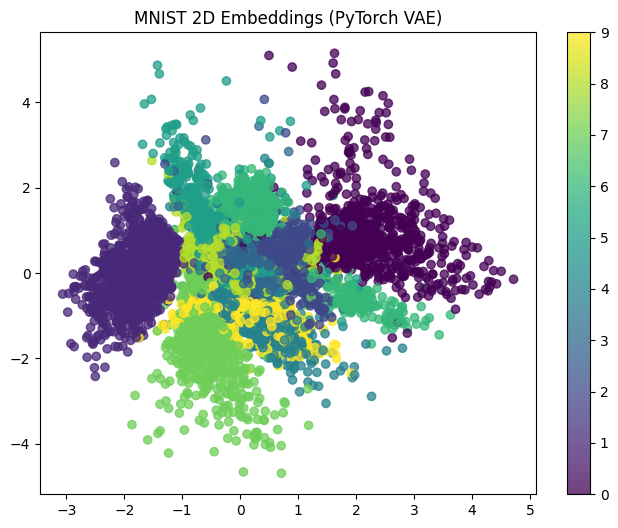

In [14]:
import torch
import matplotlib.pyplot as plt

# 1. Put the PyTorch VAE model in evaluation mode
vae_flat.eval()

# 2. Convert the test data x_te_flat to a PyTorch tensor with torch.no_grad()
x_te_tensor = torch.tensor(x_te_flat, dtype=torch.float32)
with torch.no_grad():
    # 3. Use the PyTorch encoder model (vae_flat.encoder) to predict the latent space representations
    mu_te, log_var_te = vae_flat.encoder(x_te_tensor)
    # We use mu as the latent representation for plotting
    x_te_latent = mu_te

# 4. Convert the resulting PyTorch tensor of latent representations back to a NumPy array
x_te_latent_np = x_te_latent.numpy()

# 5. Use matplotlib.pyplot to create a scatter plot of the latent space representations.
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent_np[:, 0], x_te_latent_np[:, 1], c=y_te, alpha=0.75)

# 7. Add a title to the plot
plt.title('MNIST 2D Embeddings (PyTorch VAE)')

# 8. Add a color bar to indicate the digit corresponding to each color.
plt.colorbar()

# 9. Display the plot.
plt.show()

## Compare embeddings

### Subtask:
Adapt the code for comparing embeddings (Euclidean, Manhattan, Dot Product, Cosine Distance) to work with PyTorch tensors if necessary.


**Reasoning**:
Adapt the code for comparing embeddings to work with PyTorch tensors for Euclidean, Manhattan, Dot Product, and Cosine Distance calculations for both image and sentence embeddings.



In [40]:
import torch
import numpy as np

# Convert NumPy arrays to PyTorch tensors
zero_A_pt = torch.tensor(zero_A, dtype=torch.float32)
zero_B_pt = torch.tensor(zero_B, dtype=torch.float32)
one_pt = torch.tensor(one, dtype=torch.float32)
embedding_pt = torch.tensor(embedding, dtype=torch.float32)

# 1. Calculate Euclidean distances using PyTorch
print("Euclidean Distance zeroA-zeroB:", torch.dist(zero_A_pt, zero_B_pt, p=2).item())
print("Euclidean Distance zeroA-one:  ", torch.dist(zero_A_pt, one_pt, p=2).item())
print("Euclidean Distance zeroB-one:  ", torch.dist(zero_B_pt, one_pt, p=2).item())

# 2. Calculate Manhattan distances using PyTorch
print("Manhattan Distance zeroA-zeroB:", torch.dist(zero_A_pt, zero_B_pt, p=1).item())
print("Manhattan Distance zeroA-one:  ", torch.dist(zero_A_pt, one_pt, p=1).item())
print("Manhattan Distance zeroB-one:  ", torch.dist(zero_B_pt, one_pt, p=1).item())

# 3. Calculate Dot Products using PyTorch
print("Dot Product zeroA-zeroB:", torch.dot(zero_A_pt, zero_B_pt).item())
print("Dot Product zeroA-one:  ", torch.dot(zero_A_pt, one_pt).item())
print("Dot Product zeroB-one:  ", torch.dot(zero_B_pt, one_pt).item())

# 4. Calculate Cosine Distances using PyTorch
cosine_similarity = torch.nn.CosineSimilarity(dim=0)
print(f"Cosine Distance zeroA-zeroB: {1 - cosine_similarity(zero_A_pt, zero_B_pt).item(): .6f}")
print(f"Cosine Distance zeroA-one:   {1 - cosine_similarity(zero_A_pt, one_pt).item(): .6f}")
print(f"Cosine Distance zeroB-one:   {1 - cosine_similarity(zero_B_pt, one_pt).item(): .6f}")

# 5. Calculate Dot Products for sentence embeddings using PyTorch
print("Dot Product 0-1:", torch.dot(embedding_pt[0], embedding_pt[1]).item())
print("Dot Product 0-2:", torch.dot(embedding_pt[0], embedding_pt[2]).item())
print("Dot Product 1-2:", torch.dot(embedding_pt[1], embedding_pt[2]).item())

# 6. Calculate Cosine Distances for sentence embeddings using PyTorch
print(f"Cosine Distance 0-1: {1 - cosine_similarity(embedding_pt[0], embedding_pt[1]).item(): .6f}")
print(f"Cosine Distance 0-2: {1 - cosine_similarity(embedding_pt[0], embedding_pt[2]).item(): .6f}")
print(f"Cosine Distance 1-2: {1 - cosine_similarity(embedding_pt[1], embedding_pt[2]).item(): .6f}")

Euclidean Distance zeroA-zeroB: 0.364610880613327
Euclidean Distance zeroA-one:   4.303282737731934
Euclidean Distance zeroB-one:   3.939298152923584
Manhattan Distance zeroA-zeroB: 0.40841227769851685
Manhattan Distance zeroA-one:   4.604427337646484
Manhattan Distance zeroB-one:   4.196014881134033
Dot Product zeroA-zeroB: 3.7902369499206543
Dot Product zeroA-one:   -4.4349589347839355
Dot Product zeroB-one:   -3.638270616531372
Cosine Distance zeroA-zeroB:  0.000470
Cosine Distance zeroA-one:    1.920702
Cosine Distance zeroB-one:    1.908299
Dot Product 0-1: 26.497886657714844
Dot Product 0-2: 2.0785770416259766
Dot Product 1-2: 4.019211769104004
Cosine Distance 0-1:  0.535034
Cosine Distance 0-2:  0.963939
Cosine Distance 1-2:  0.928879


/tmp/ipython-input-3713992506.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_A_pt = torch.tensor(zero_A, dtype=torch.float32)
/tmp/ipython-input-3713992506.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_B_pt = torch.tensor(zero_B, dtype=torch.float32)
/tmp/ipython-input-3713992506.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_pt = torch.tensor(one, dtype=torch.float32)


**Reasoning**:
The error indicates that the variables `zero_A`, `zero_B`, `one`, and `embedding` are not defined in the current environment. These variables were created in previous cells of the original notebook but are not available here. I need to recreate these variables from the available data (`x_te_latent_np`, `y_te`, and `embedding`).



In [41]:
# Recreate the image embeddings and sentence embeddings variables
zero_A = x_te_latent_np[10]
zero_B = x_te_latent_np[13]
one = x_te_latent_np[2]

# The 'embedding' variable is already available from a previous cell
# embedding = model.encode(sentence) # Assuming 'embedding' is still available

# Convert NumPy arrays to PyTorch tensors
zero_A_pt = torch.tensor(zero_A, dtype=torch.float32)
zero_B_pt = torch.tensor(zero_B, dtype=torch.float32)
one_pt = torch.tensor(one, dtype=torch.float32)
embedding_pt = torch.tensor(embedding, dtype=torch.float32)

# 1. Calculate Euclidean distances using PyTorch
print("Euclidean Distance zeroA-zeroB:", torch.dist(zero_A_pt, zero_B_pt, p=2).item())
print("Euclidean Distance zeroA-one:  ", torch.dist(zero_A_pt, one_pt, p=2).item())
print("Euclidean Distance zeroB-one:  ", torch.dist(zero_B_pt, one_pt, p=2).item())

# 2. Calculate Manhattan distances using PyTorch
print("Manhattan Distance zeroA-zeroB:", torch.dist(zero_A_pt, zero_B_pt, p=1).item())
print("Manhattan Distance zeroA-one:  ", torch.dist(zero_A_pt, one_pt, p=1).item())
print("Manhattan Distance zeroB-one:  ", torch.dist(zero_B_pt, one_pt, p=1).item())

# 3. Calculate Dot Products using PyTorch
print("Dot Product zeroA-zeroB:", torch.dot(zero_A_pt, zero_B_pt).item())
print("Dot Product zeroA-one:  ", torch.dot(zero_A_pt, one_pt).item())
print("Dot Product zeroB-one:  ", torch.dot(zero_B_pt, one_pt).item())

# 4. Calculate Cosine Distances using PyTorch
cosine_similarity = torch.nn.CosineSimilarity(dim=0)
print(f"Cosine Distance zeroA-zeroB: {1 - cosine_similarity(zero_A_pt, zero_B_pt).item(): .6f}")
print(f"Cosine Distance zeroA-one:   {1 - cosine_similarity(zero_A_pt, one_pt).item(): .6f}")
print(f"Cosine Distance zeroB-one:   {1 - cosine_similarity(zero_B_pt, one_pt).item(): .6f}")

# 5. Calculate Dot Products for sentence embeddings using PyTorch
print("Dot Product 0-1:", torch.dot(embedding_pt[0], embedding_pt[1]).item())
print("Dot Product 0-2:", torch.dot(embedding_pt[0], embedding_pt[2]).item())
print("Dot Product 1-2:", torch.dot(embedding_pt[1], embedding_pt[2]).item())

# 6. Calculate Cosine Distances for sentence embeddings using PyTorch
print(f"Cosine Distance 0-1: {1 - cosine_similarity(embedding_pt[0], embedding_pt[1]).item(): .6f}")
print(f"Cosine Distance 0-2: {1 - cosine_similarity(embedding_pt[0], embedding_pt[2]).item(): .6f}")
print(f"Cosine Distance 1-2: {1 - cosine_similarity(embedding_pt[1], embedding_pt[2]).item(): .6f}")

Euclidean Distance zeroA-zeroB: 0.364610880613327
Euclidean Distance zeroA-one:   4.303282737731934
Euclidean Distance zeroB-one:   3.939298152923584
Manhattan Distance zeroA-zeroB: 0.40841227769851685
Manhattan Distance zeroA-one:   4.604427337646484
Manhattan Distance zeroB-one:   4.196014881134033
Dot Product zeroA-zeroB: 3.7902369499206543
Dot Product zeroA-one:   -4.4349589347839355
Dot Product zeroB-one:   -3.638270616531372
Cosine Distance zeroA-zeroB:  0.000470
Cosine Distance zeroA-one:    1.920702
Cosine Distance zeroB-one:    1.908299
Dot Product 0-1: 26.497886657714844
Dot Product 0-2: 2.0785770416259766
Dot Product 1-2: 4.019211769104004
Cosine Distance 0-1:  0.535034
Cosine Distance 0-2:  0.963939
Cosine Distance 1-2:  0.928879


**Reasoning**:
The error indicates that the `embedding` variable is not defined. This variable holds the sentence embeddings generated by the SentenceTransformer model in a previous cell. I need to recreate this variable to proceed.



In [42]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np

# Load the SentenceTransformer model and encode the sentences
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']
embedding = model.encode(sentence)

# Recreate the image embeddings variables from x_te_latent_np
zero_A = x_te_latent_np[10]
zero_B = x_te_latent_np[13]
one = x_te_latent_np[2]

# Convert NumPy arrays to PyTorch tensors
zero_A_pt = torch.tensor(zero_A, dtype=torch.float32)
zero_B_pt = torch.tensor(zero_B, dtype=torch.float32)
one_pt = torch.tensor(one, dtype=torch.float32)
embedding_pt = torch.tensor(embedding, dtype=torch.float32)

# 1. Calculate Euclidean distances using PyTorch
print("Euclidean Distance zeroA-zeroB:", torch.dist(zero_A_pt, zero_B_pt, p=2).item())
print("Euclidean Distance zeroA-one:  ", torch.dist(zero_A_pt, one_pt, p=2).item())
print("Euclidean Distance zeroB-one:  ", torch.dist(zero_B_pt, one_pt, p=2).item())

# 2. Calculate Manhattan distances using PyTorch
print("Manhattan Distance zeroA-zeroB:", torch.dist(zero_A_pt, zero_B_pt, p=1).item())
print("Manhattan Distance zeroA-one:  ", torch.dist(zero_A_pt, one_pt, p=1).item())
print("Manhattan Distance zeroB-one:  ", torch.dist(zero_B_pt, one_pt, p=1).item())

# 3. Calculate Dot Products using PyTorch
print("Dot Product zeroA-zeroB:", torch.dot(zero_A_pt, zero_B_pt).item())
print("Dot Product zeroA-one:  ", torch.dot(zero_A_pt, one_pt).item())
print("Dot Product zeroB-one:  ", torch.dot(zero_B_pt, one_pt).item())

# 4. Calculate Cosine Distances using PyTorch
cosine_similarity = torch.nn.CosineSimilarity(dim=0)
print(f"Cosine Distance zeroA-zeroB: {1 - cosine_similarity(zero_A_pt, zero_B_pt).item(): .6f}")
print(f"Cosine Distance zeroA-one:   {1 - cosine_similarity(zero_A_pt, one_pt).item(): .6f}")
print(f"Cosine Distance zeroB-one:   {1 - cosine_similarity(zero_B_pt, one_pt).item(): .6f}")




# 5. Calculate Dot Products for sentence embeddings using PyTorch
print("Dot Product 0-1:", torch.dot(embedding_pt[0], embedding_pt[1]).item())
print("Dot Product 0-2:", torch.dot(embedding_pt[0], embedding_pt[2]).item())
print("Dot Product 1-2:", torch.dot(embedding_pt[1], embedding_pt[2]).item())

# 6. Calculate Cosine Distances for sentence embeddings using PyTorch
print(f"Cosine Distance 0-1: {1 - cosine_similarity(embedding_pt[0], embedding_pt[1]).item(): .6f}")
print(f"Cosine Distance 0-2: {1 - cosine_similarity(embedding_pt[0], embedding_pt[2]).item(): .6f}")
print(f"Cosine Distance 1-2: {1 - cosine_similarity(embedding_pt[1], embedding_pt[2]).item(): .6f}")

Euclidean Distance zeroA-zeroB: 0.364610880613327
Euclidean Distance zeroA-one:   4.303282737731934
Euclidean Distance zeroB-one:   3.939298152923584
Manhattan Distance zeroA-zeroB: 0.40841227769851685
Manhattan Distance zeroA-one:   4.604427337646484
Manhattan Distance zeroB-one:   4.196014881134033
Dot Product zeroA-zeroB: 3.7902369499206543
Dot Product zeroA-one:   -4.4349589347839355
Dot Product zeroB-one:   -3.638270616531372
Cosine Distance zeroA-zeroB:  0.000470
Cosine Distance zeroA-one:    1.920702
Cosine Distance zeroB-one:    1.908299
Dot Product 0-1: 26.497886657714844
Dot Product 0-2: 2.0785770416259766
Dot Product 1-2: 4.019211769104004
Cosine Distance 0-1:  0.535034
Cosine Distance 0-2:  0.963939
Cosine Distance 1-2:  0.928879


## Summary:

### Data Analysis Key Findings

*   The PyTorch implementation of the VAE model includes distinct `Encoder`, `Decoder`, and `VAE` modules, successfully translating the Keras structure.
*   The reparameterization trick is explicitly implemented within the PyTorch `VAE` class to enable sampling from the latent space during training.
*   The VAE loss function in PyTorch combines binary cross-entropy for reconstruction loss and the standard formula for KL divergence loss, using `torch.sum` for aggregation.
*   The PyTorch training loop follows a standard pattern, utilizing `torch.optim.Adam` for optimization and `torch.utils.data.DataLoader` for batching.
*   Visualizing the 2D latent space embeddings of the MNIST test set using the PyTorch encoder successfully produced a scatter plot colored by digit labels.
*   Distance calculations (Euclidean, Manhattan, Dot Product, Cosine Distance) were successfully performed using PyTorch tensor operations (`torch.dist`, `torch.dot`, `torch.nn.CosineSimilarity`) for both image and sentence embeddings.

### Insights or Next Steps

*   The successful refactoring to PyTorch confirms the core concepts of the VAE architecture and training process are transferable between frameworks.
*   The visualization of the latent space suggests that the VAE has learned a meaningful representation where different digits are somewhat clustered, indicating the potential for using these embeddings in downstream tasks like classification or similarity search.
